In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.models import Model
from keras.optimizers import RMSprop, Adam
from keras.callbacks import CSVLogger
from livelossplot import PlotLossesKeras
from keras.models import Sequential
from src.img_utils import image_to_imagedatagen
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

"""
cnn_classifier.py  
Linh Chau
"""

class CNN_Classifier():
    def __init__(self):
        self.classifier = None
        self.log_file = None

    def fit(self, X_train, X_test, batch_size = 32, n_epochs = 15):
        self.log_file = f'{X_train}_cnnclassifier_log.csv'
        self.classifier.fit(X_train,
                            validation_data = X_test,
                            steps_per_epoch = len(X_train.filenames) // batch_size,
                            validation_steps =  len(X_test.filenames) // batch_size,
                            epochs = n_epochs, 
                            callbacks=[PlotLossesKeras(), CSVLogger(self.log_file,
                                        append=False,
                                        separator=";")], 
                            # verbose = 1
        )

    def predict(self, X):
        return self.classifier.predict_generator(X)

    def compile(self, opt = 'adam', loss_func = 'binary_crossentropy'):
        self.classifier.compile(optimizer = opt, loss = loss_func, metrics=['accuracy'])
        print(self.classifier.summary())
    
    def set_architecture(self, img_width, img_height, img_channel):
        """
        Architecture inspired by ...
        """
        input_shape = (img_width, img_height, img_channel)

        self.classifier = Sequential()

        self.classifier.add(Conv2D(32, (3, 3), input_shape=input_shape))
        self.classifier.add(Activation('relu'))
        self.classifier.add(MaxPooling2D(pool_size=(2, 2)))

        self.classifier.add(Conv2D(64, (3, 3)))
        self.classifier.add(Activation('relu'))
        self.classifier.add(MaxPooling2D(pool_size=(2, 2)))

        self.classifier.add(Conv2D(128, (3, 3)))
        self.classifier.add(Activation('relu'))
        self.classifier.add(MaxPooling2D(pool_size=(2, 2)))

        self.classifier.add(Flatten())
        self.classifier.add(Dense(128))
        self.classifier.add(Activation('relu'))
        self.classifier.add(Dropout(0.5))
        self.classifier.add(Dense(1))
        self.classifier.add(Activation('sigmoid'))

    def metrics(self, X):
        return self.classifier.evaluate_generator(X)




ModuleNotFoundError: No module named 'jewelery_recommender'

In [7]:
# Read in Data
datasets = {
    'test':'/Users/linhchau/Desktop/galvanize/jewelery_recommender/data/testing_full',
    'train':'/Users/linhchau/Desktop/galvanize/jewelery_recommender/data/training_full'
}

key_to_generator = {k: image_to_imagedatagen(v) for k,v in datasets.items()}

# Hyperparameters
img_size = 100
img_width, img_height = img_size, img_size
n_epochs = 15
batch_size = 32
test_size = 30 ##CHECK THIS
channels = 3 # color
class_mode = 'binary'

input_shape = (img_width, img_height, channels)



Found 2576 images belonging to 2 classes.
Found 23155 images belonging to 2 classes.


In [43]:
import re
train_ids = key_to_generator['train'].filenames
train_ids[0:11]

['necklaces/113277145.jpg',
 'necklaces/118378803.jpg',
 'necklaces/139377319.jpg',
 'necklaces/161080128.jpg',
 'necklaces/202982050.jpg',
 'necklaces/210253520.jpg',
 'necklaces/210275662.jpg',
 'necklaces/230380759.jpg',
 'necklaces/244140427.jpg',
 'necklaces/244150953.jpg',
 'necklaces/246223047.jpg']

In [50]:
train_files = pd.DataFrame([re.split('[./]', i)[-2] for i in train_ids])
train_files.to_csv('data/training_files.csv', index=False, header=False)

In [34]:
key_to_generator['test'].class_indices

{'necklaces': 0, 'segmented_earrings': 1}

In [8]:
model = CNN_Classifier()
model.set_architecture(img_width, img_height, channels)
model.compile()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
activation_6 (Activation)    (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
activation_7 (Activation)    (None, 47, 47, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 21, 21, 128)      

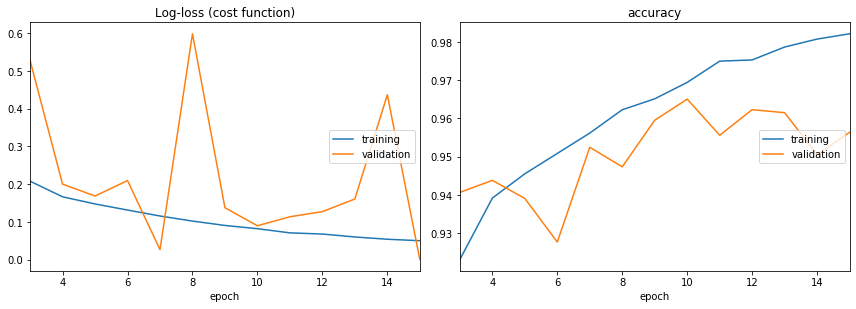

Log-loss (cost function):
training   (min:    0.050, max:    0.326, cur:    0.050)
validation (min:    0.001, max:    0.598, cur:    0.001)

accuracy:
training   (min:    0.857, max:    0.982, cur:    0.982)
validation (min:    0.916, max:    0.965, cur:    0.956)


In [9]:
model.fit(key_to_generator['train'], key_to_generator['test'])

In [15]:
model.metrics(key_to_generator['test'])

[0.0007602183031849563, 0.9553571343421936]

In [11]:
pkl_filename = 'jewelry_final_cnn_classifer.pkl'
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

In [7]:
# Load from file
import pickle
with open('/Users/linhchau/Desktop/galvanize/jewelery_recommender/models/jewelry_final_cnn_classifer.pkl', 'rb') as file:
    pickle_model = pickle.load(file)

AttributeError: Can't get attribute 'CNN_Classifier' on <module '__main__'>

In [ ]:
pickle_model.metrics(key_to_generator['test'])

In [23]:
predictions = pickle_model.predict(key_to_generator['test'])

In [24]:
predictions

array([[0.        ],
       [0.        ],
       [1.        ],
       ...,
       [0.        ],
       [0.40745384],
       [0.01409158]], dtype=float32)

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')